In [2]:
# --- 1. Importing Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

print("All required libraries imported successfully.")

All required libraries imported successfully.


In [6]:
# --- CORRECTED 2. Data Loading and Saving ---

# Define the stock symbols (NSE symbols)
symbols = {
    "TCS": "TCS.NS",
    "Infosys": "INFY.NS",
    "ITC": "ITC.NS",
    "YesBank": "YESBANK.NS",
    "HDFCBank": "HDFCBANK.NS"
}
start_date = "2020-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")
stock_data = {}

print(f"Starting data download from {start_date} to {end_date}...")

for company, symbol in symbols.items():
    # Download the data
    df = yf.download(symbol, start=start_date, end=end_date)

    # RESET THE INDEX so 'Date' moves from being the index to being a regular column
    df = df.reset_index()

    filename = f"{company}_stock_data.csv"

    # Save to CSV
    df.to_csv(filename, index=False) # Use index=False so the old index isn't saved as an unnamed column

    # Load the saved CSV back into the dictionary
    # The 'Date' column is now guaranteed to be a column named 'Date'
    stock_data[company] = pd.read_csv(filename)

    print(f"✅ Downloaded and saved data for {company} to '{filename}'")

print("\nAll 5 datasets are now loaded into the 'stock_data' dictionary.")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Starting data download from 2020-01-01 to 2025-10-21...
✅ Downloaded and saved data for TCS to 'TCS_stock_data.csv'
✅ Downloaded and saved data for Infosys to 'Infosys_stock_data.csv'
✅ Downloaded and saved data for ITC to 'ITC_stock_data.csv'



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ Downloaded and saved data for YesBank to 'YesBank_stock_data.csv'
✅ Downloaded and saved data for HDFCBank to 'HDFCBank_stock_data.csv'

All 5 datasets are now loaded into the 'stock_data' dictionary.


In [7]:
# --- 3. Printing Values (Shape and Head) ---

print("\n--- Summary of Loaded DataFrames ---")

for company, df in stock_data.items():
    print(f"\n[COMPANY: {company}]")
    print(f"Data Shape: {df.shape}")
    print(df.head())
    print("-" * 50)


--- Summary of Loaded DataFrames ---

[COMPANY: TCS]
Data Shape: (1439, 6)
         Date               Close                High                Low  \
0         NaN              TCS.NS              TCS.NS             TCS.NS   
1  2020-01-01   1900.037841796875  1914.3256459696258  1888.116500666217   
2  2020-01-02  1891.3157958984375  1910.8631907524984  1883.908882428102   
3  2020-01-03    1929.00830078125  1948.5995696406267   1896.88235209281   
4  2020-01-06   1928.832763671875   1951.185117310929  1917.831856628987   

                 Open   Volume  
0              TCS.NS   TCS.NS  
1  1900.3883813576408  1354908  
2  1910.8631907524984  2380752  
3    1896.88235209281  4655761  
4  1932.8211676123146  3023209  
--------------------------------------------------

[COMPANY: Infosys]
Data Shape: (1439, 6)
         Date              Close               High                Low  \
0         NaN            INFY.NS            INFY.NS            INFY.NS   
1  2020-01-01  642.843933105

In [10]:
# --- Final Corrected Preprocessing for All 5 Datasets ---
# Assuming 'stock_data' dictionary is correctly loaded from the previous step.

processed_stock_data = {}

print("--- Starting Preprocessing (Numeric Conversion, Date Conversion, & Outlier Removal) ---")

for company, df in stock_data.items():
    print(f"\n[Processing: {company}]")
    initial_shape = df.shape
    print(f"Initial Shape: {initial_shape}")

    # 1. Date Conversion and Dropping Invalid Dates
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")
    df = df.dropna(subset=["Date"])

    # 2. Convert Price and Volume columns to numeric
    # NOTE: 'Adj Close' is removed because it's often dropped by modern yfinance!
    # The 'Close' column already contains the adjusted prices by default.
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume'] # The correct column list

    for col in numeric_cols:
        # Clean up any commas or non-numeric characters before conversion if present
        if df[col].dtype == 'object':
             df[col] = df[col].astype(str).str.replace(r'[$,]', '', regex=True)

        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop any rows where the conversion resulted in NaN (i.e., truly bad data)
    df = df.dropna(subset=numeric_cols)

    # 3. Outlier Handling (IQR method on 'Close' price)
    Q1 = df['Close'].quantile(0.25)
    Q3 = df['Close'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to remove outliers
    df = df[(df['Close'] >= lower_bound) & (df['Close'] <= upper_bound)]

    # Store the processed DataFrame
    processed_stock_data[company] = df

    final_shape = df.shape
    rows_removed = initial_shape[0] - final_shape[0]

    print(f"After Preprocessing Shape: {final_shape}")
    print(f"Rows removed (Bad Data/Outliers): {rows_removed}")
    print("-" * 50)

print("--- Preprocessing Complete. DataFrames are stored in 'processed_stock_data' ---")

--- Starting Preprocessing (Numeric Conversion, Date Conversion, & Outlier Removal) ---

[Processing: TCS]
Initial Shape: (1439, 6)
After Preprocessing Shape: (1311, 6)
Rows removed (Bad Data/Outliers): 128
--------------------------------------------------

[Processing: Infosys]
Initial Shape: (1439, 6)
After Preprocessing Shape: (1313, 6)
Rows removed (Bad Data/Outliers): 126
--------------------------------------------------

[Processing: ITC]
Initial Shape: (1439, 6)
After Preprocessing Shape: (1438, 6)
Rows removed (Bad Data/Outliers): 1
--------------------------------------------------

[Processing: YesBank]
Initial Shape: (1439, 6)
After Preprocessing Shape: (1388, 6)
Rows removed (Bad Data/Outliers): 51
--------------------------------------------------

[Processing: HDFCBank]
Initial Shape: (1439, 6)
After Preprocessing Shape: (1352, 6)
Rows removed (Bad Data/Outliers): 87
--------------------------------------------------
--- Preprocessing Complete. DataFrames are stored in 

--- Generating Closing Price Trend Visualizations ---


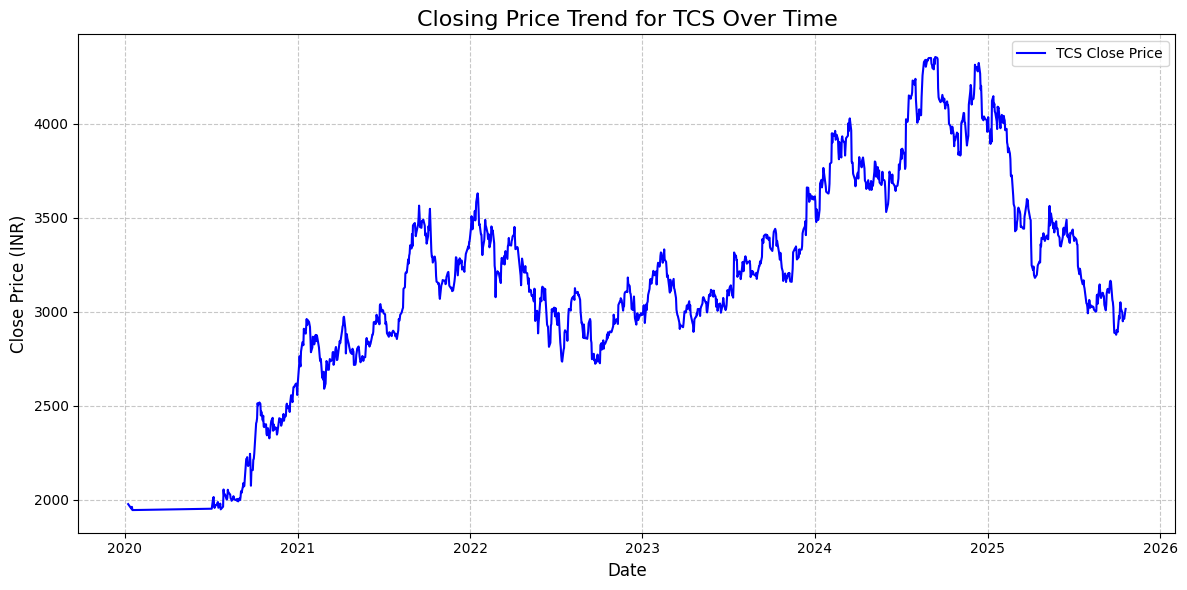

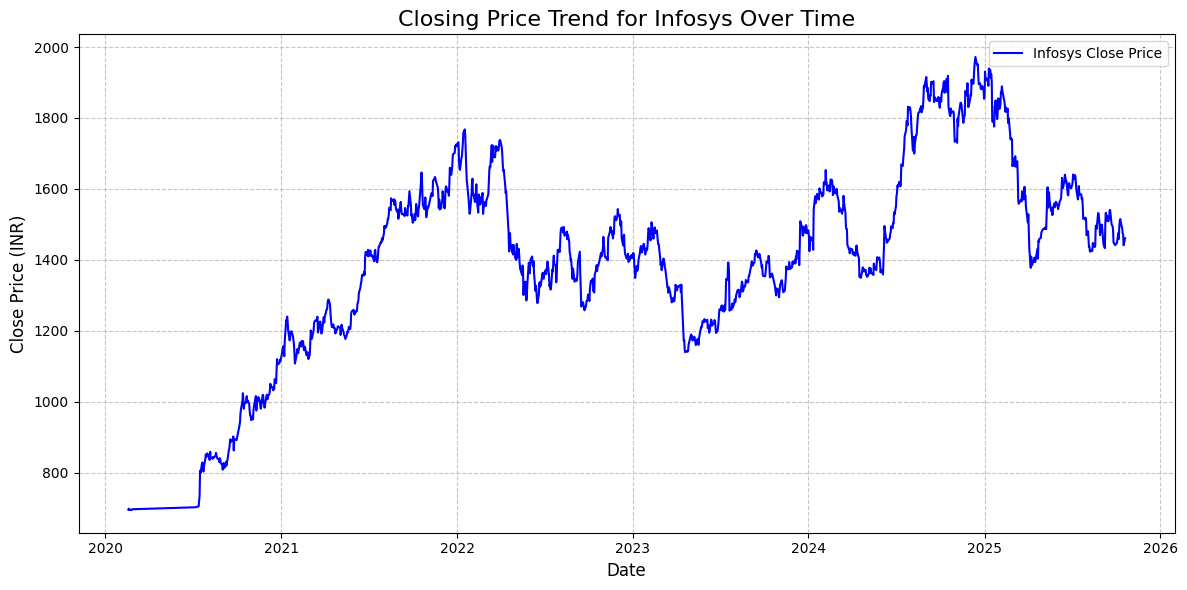

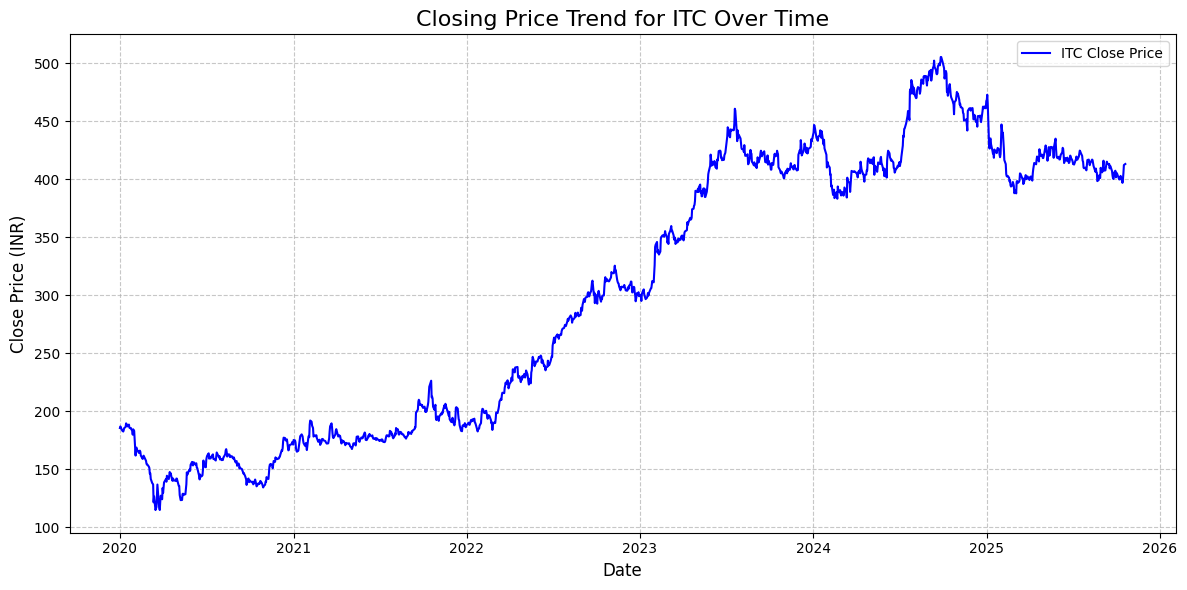

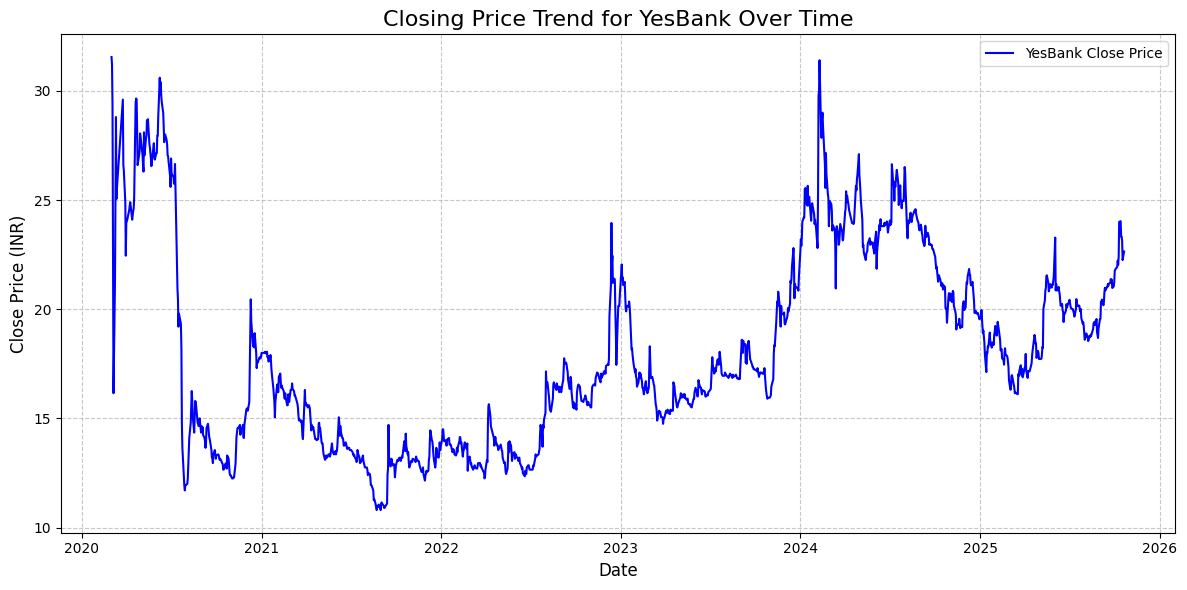

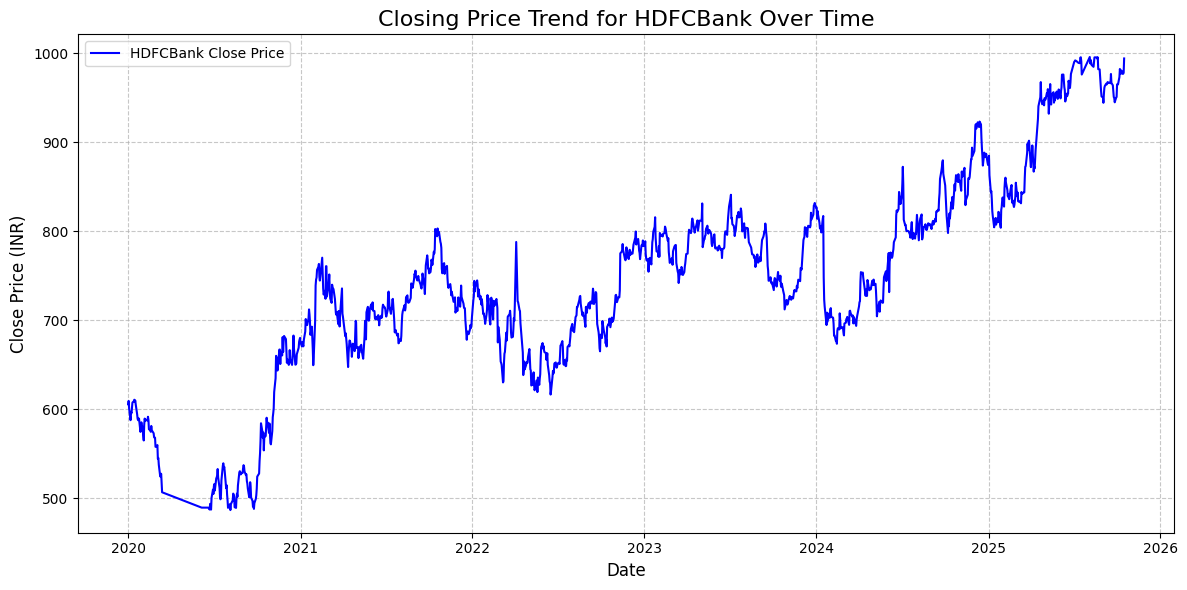

--- All closing price trend plots generated. ---


In [11]:
# --- Visualization: Closing Price Trend for All 5 Datasets ---

print("--- Generating Closing Price Trend Visualizations ---")

# Assuming processed_stock_data dictionary contains the clean dataframes

for company, df in processed_stock_data.items():

    # 1. Prepare Data
    # Set Date as the index for better plotting, although the previous code already used df["Date"] as the x-axis.
    # We will use the 'Date' column directly as the x-axis for simplicity and consistency with your request.

    # 2. Create the Plot
    plt.figure(figsize=(12, 6))

    # Plotting the Date vs. Close Price
    plt.plot(df["Date"], df["Close"], label=f"{company} Close Price", color="blue")

    # 3. Add Titles and Labels
    plt.title(f"Closing Price Trend for {company} Over Time", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Close Price (INR)", fontsize=12)

    # 4. Final Touches
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout() # Adjust plot to prevent labels from overlapping
    plt.show()

print("--- All closing price trend plots generated. ---")

--- Generating Correlation Heatmaps ---


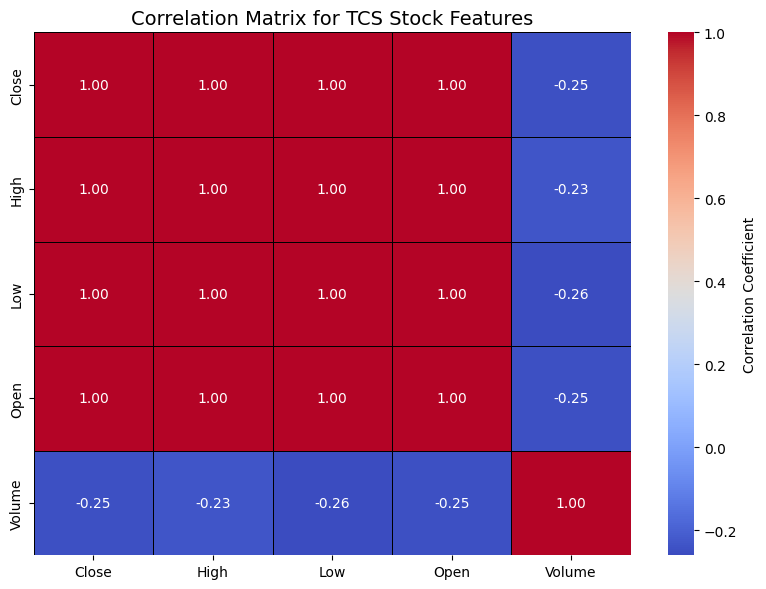

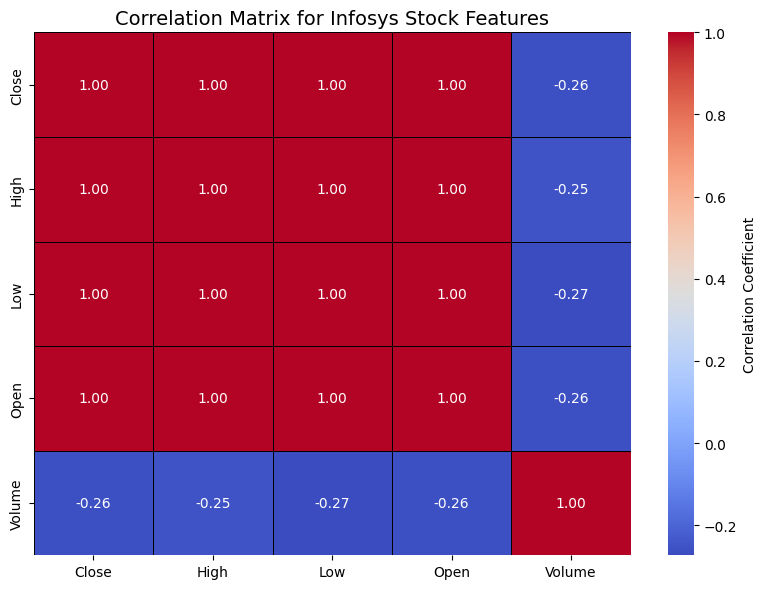

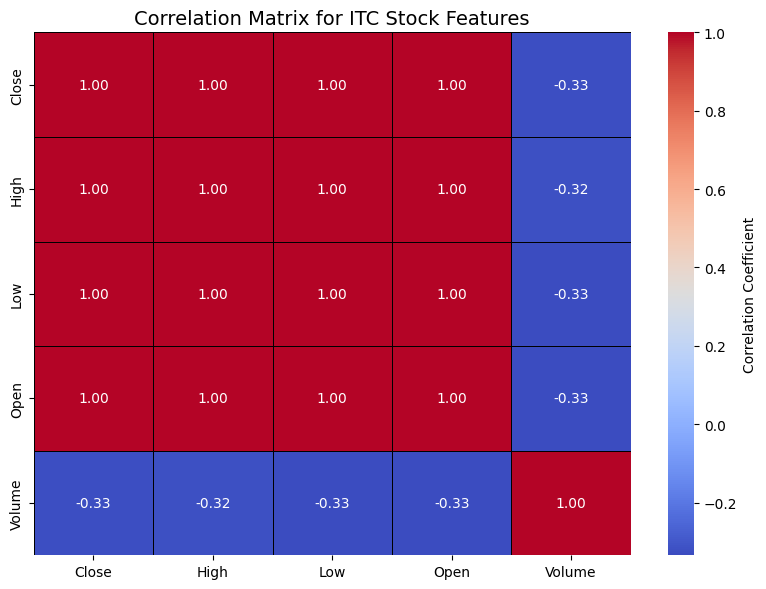

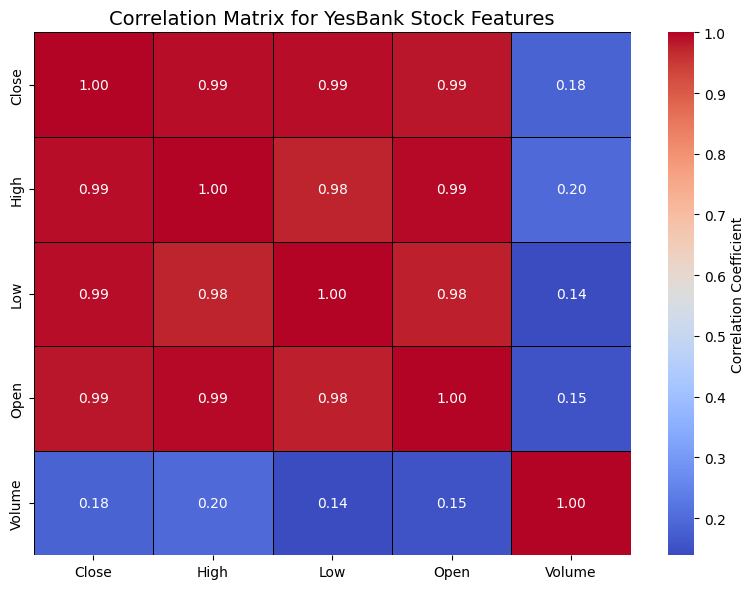

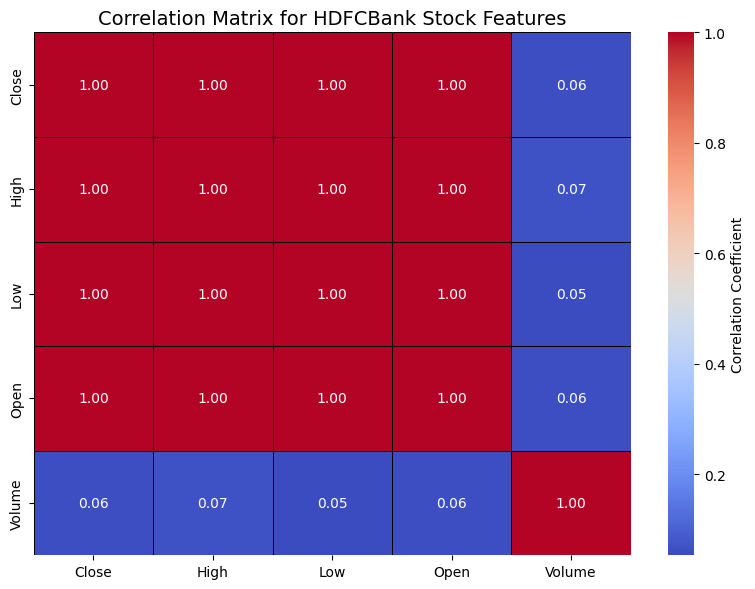

--- All correlation heatmaps generated. ---


In [12]:
# --- 4. Correlation Heatmap for All 5 Datasets ---

print("--- Generating Correlation Heatmaps ---")

# Columns for correlation analysis (Close, High, Low, Open, Volume)
corr_cols = ["Close", "High", "Low", "Open", "Volume"]

# Loop through each processed DataFrame
for company, df in processed_stock_data.items():

    # Check if the DataFrame has all required columns and is not empty
    if not df.empty and all(col in df.columns for col in corr_cols):

        # 1. Calculate correlation matrix
        corr_matrix = df[corr_cols].corr()

        # 2. Create the Plot
        plt.figure(figsize=(8, 6))

        # Generate the heatmap
        # 'annot=True' displays the correlation values
        # 'cmap="coolwarm"' provides a good color divergence for correlation values
        sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",
                    linewidths=.5, linecolor='black', cbar_kws={'label': 'Correlation Coefficient'})

        # 3. Add Titles and Labels
        plt.title(f"Correlation Matrix for {company} Stock Features", fontsize=14)

        # 4. Save and Show the Plot
        # You should replace plt.show() with a save function if running in a non-interactive environment
        # For a standard notebook/script setup:
        plt.tight_layout()
        plt.show()

    else:
        print(f"Skipping {company}: DataFrame is empty or missing required columns.")

print("--- All correlation heatmaps generated. ---")

In [14]:
# --- 1. Calculate 50-Day and 200-Day Moving Averages ---

print("--- Calculating 50-Day and 200-Day Moving Averages ---")

# Iterate through each DataFrame in the dictionary
for company, df in processed_stock_data.items():
    # Calculate 50-Day Moving Average
    df['MA50'] = df['Close'].rolling(window=50).mean()

    # Calculate 200-Day Moving Average
    df['MA200'] = df['Close'].rolling(window=200).mean()

    # Update the processed_stock_data dictionary
    processed_stock_data[company] = df

    print(f"✅ MA50 and MA200 calculated for {company}.")

--- Calculating 50-Day and 200-Day Moving Averages ---
✅ MA50 and MA200 calculated for TCS.
✅ MA50 and MA200 calculated for Infosys.
✅ MA50 and MA200 calculated for ITC.
✅ MA50 and MA200 calculated for YesBank.
✅ MA50 and MA200 calculated for HDFCBank.



--- Generating 50-Day and 200-Day Moving Average Plots ---


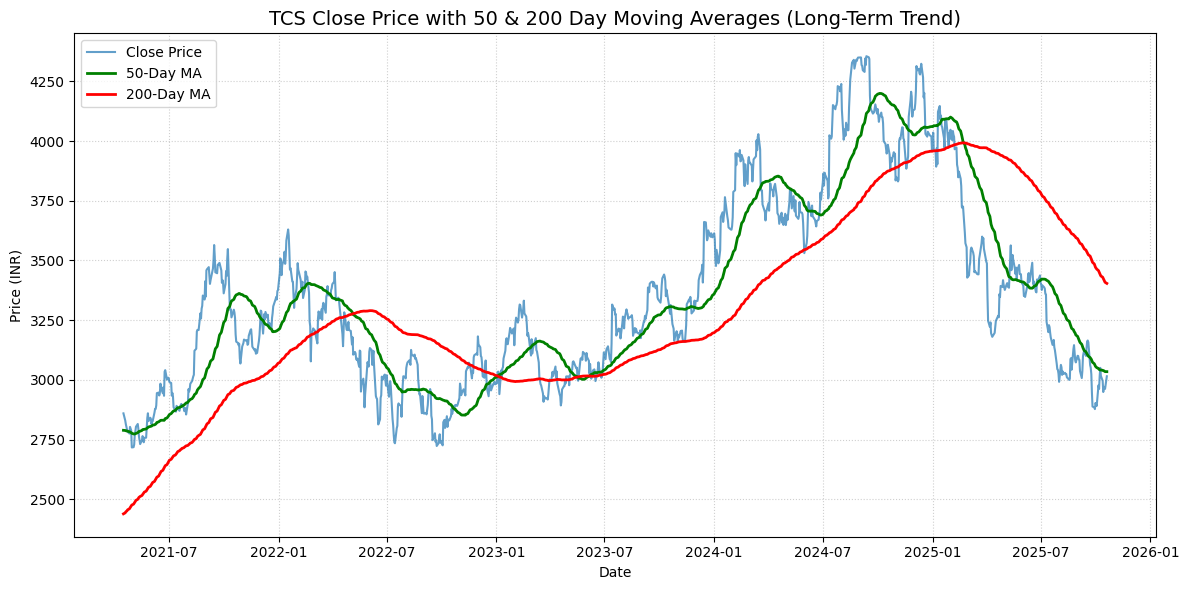

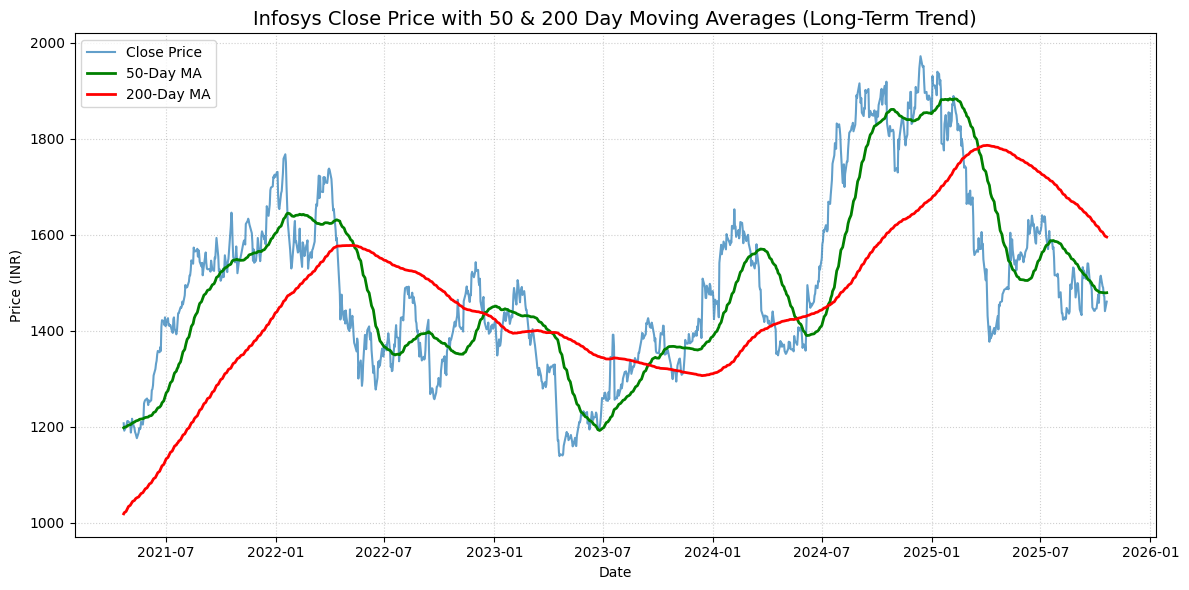

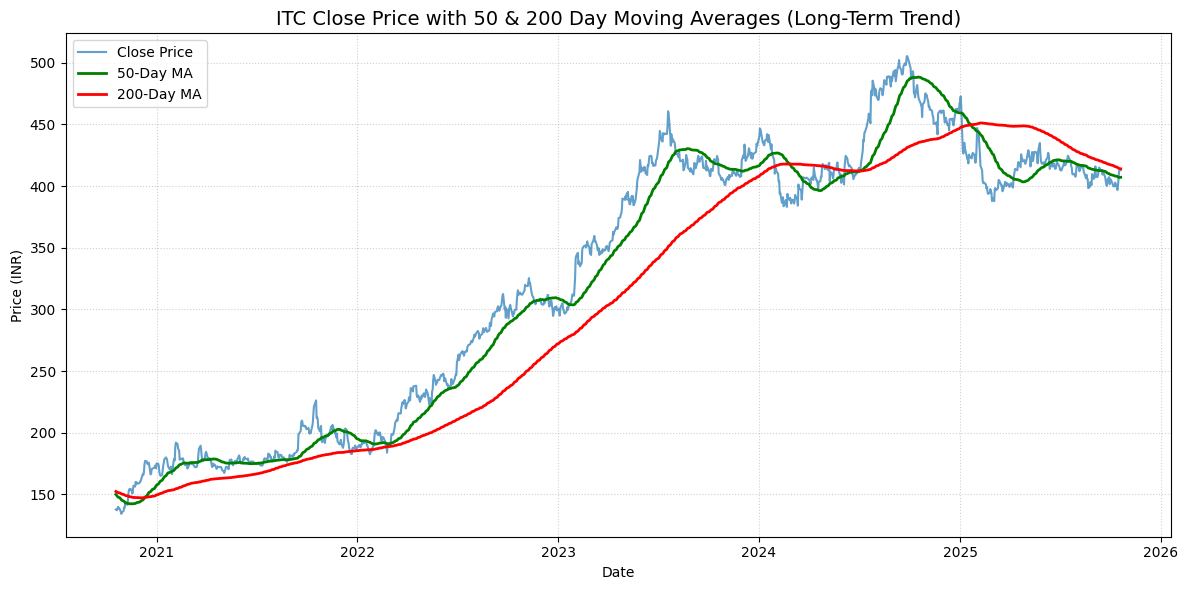

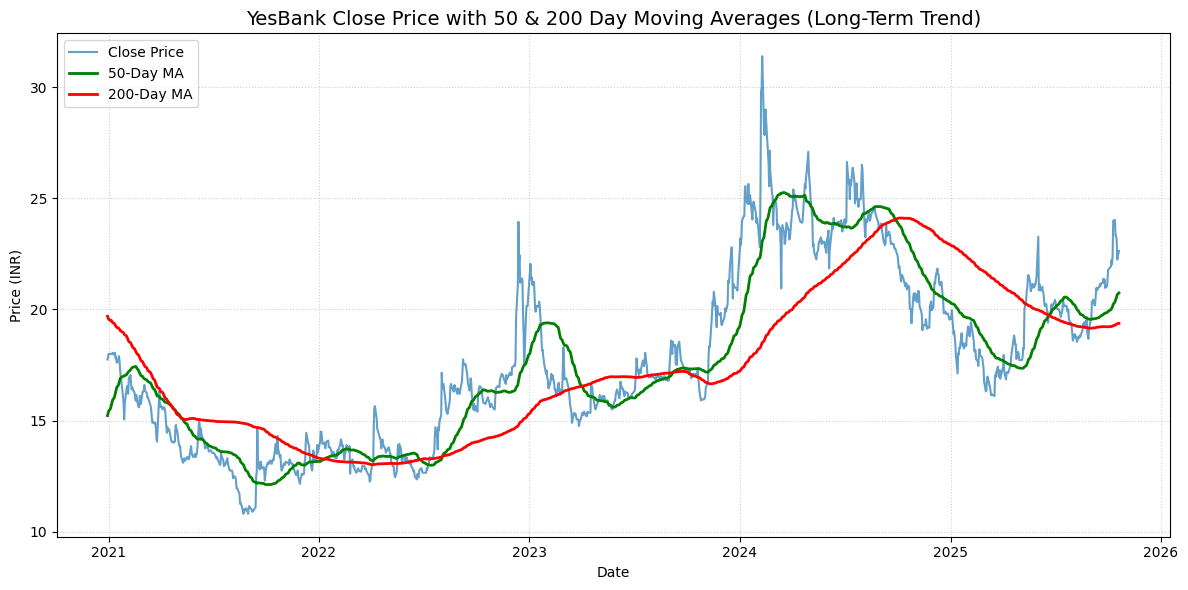

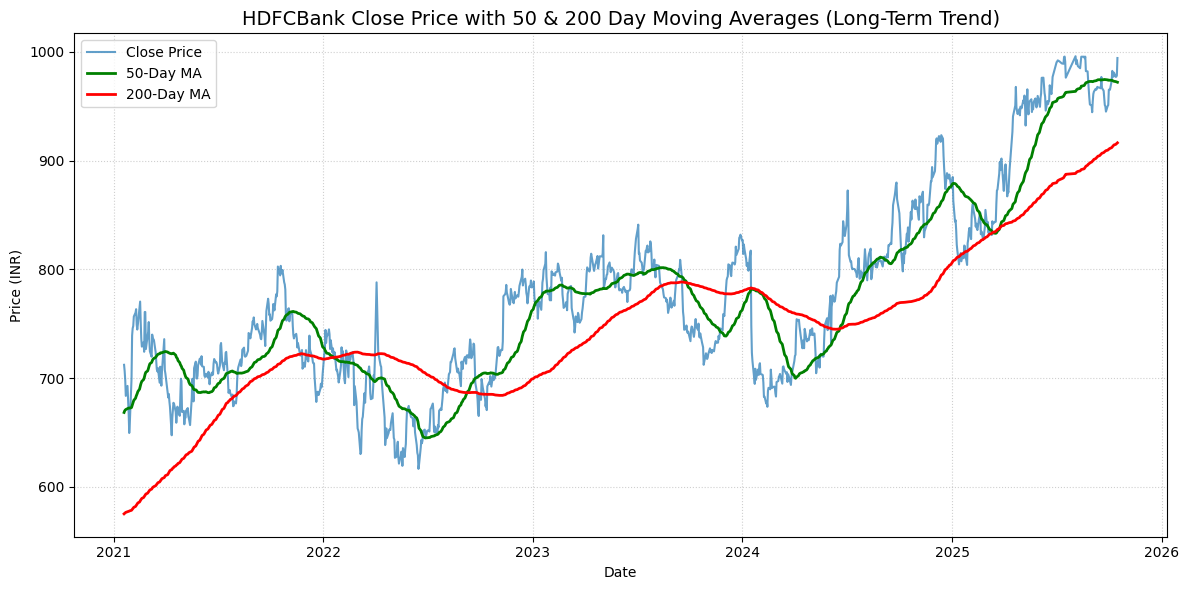

--- All 50-Day and 200-Day MA plots generated. ---


In [15]:
# --- 2. Plot Close Price with 50-Day and 200-Day Moving Averages ---

print("\n--- Generating 50-Day and 200-Day Moving Average Plots ---")

# Loop through each processed DataFrame with MAs
for company, df in processed_stock_data.items():

    # Drop initial rows where MA values are NaN (before 200th day)
    # We drop NaN in MA200 as it requires the most data points.
    df_plot = df.dropna(subset=['MA200'])

    if not df_plot.empty:
        plt.figure(figsize=(12, 6))

        # Plot Close Price
        plt.plot(df_plot["Date"], df_plot["Close"], label="Close Price", alpha=0.7, color="#1f77b4")

        # Plot 50-Day MA
        plt.plot(df_plot["Date"], df_plot["MA50"], label="50-Day MA", color="green", linewidth=2)

        # Plot 200-Day MA
        plt.plot(df_plot["Date"], df_plot["MA200"], label="200-Day MA", color="red", linewidth=2)

        # Add Titles and Labels
        plt.title(f"{company} Close Price with 50 & 200 Day Moving Averages (Long-Term Trend)", fontsize=14)
        plt.xlabel("Date", fontsize=10)
        plt.ylabel("Price (INR)", fontsize=10)

        # Add Legend and Grid
        plt.legend(loc='upper left')
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping plot for {company}: Not enough data points to calculate 200-day MA.")

print("--- All 50-Day and 200-Day MA plots generated. ---")

--- Calculating 14-Day RSI and Generating Plots ---


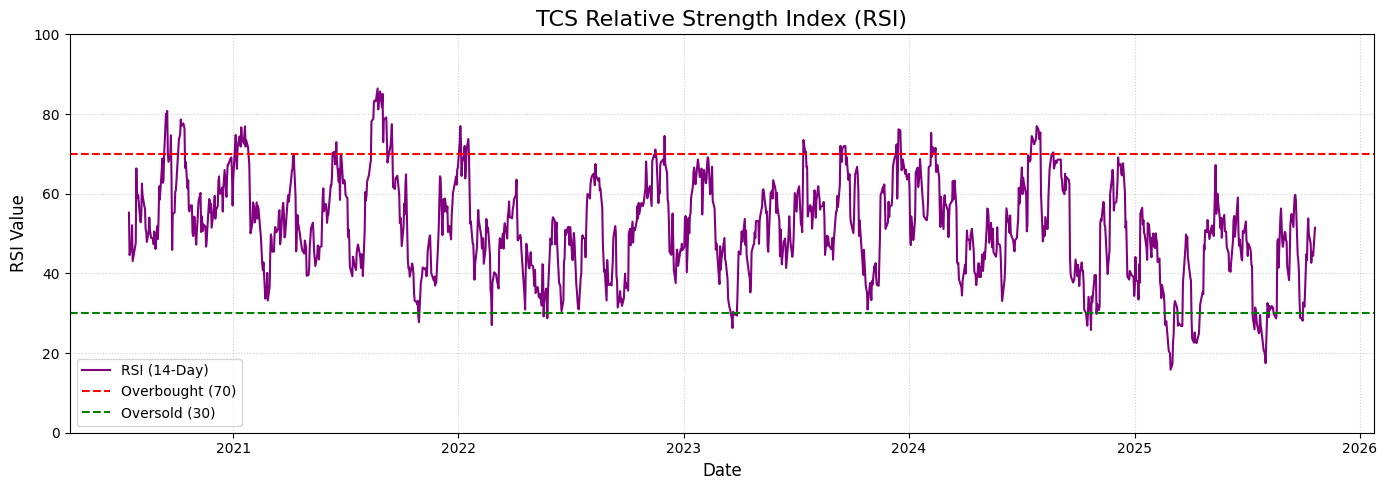

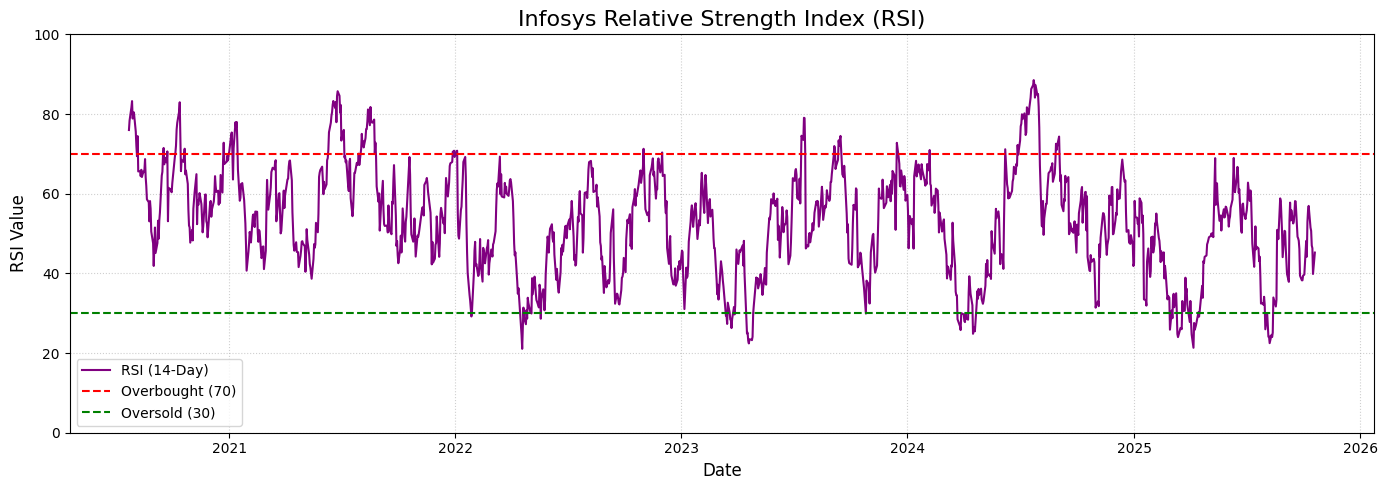

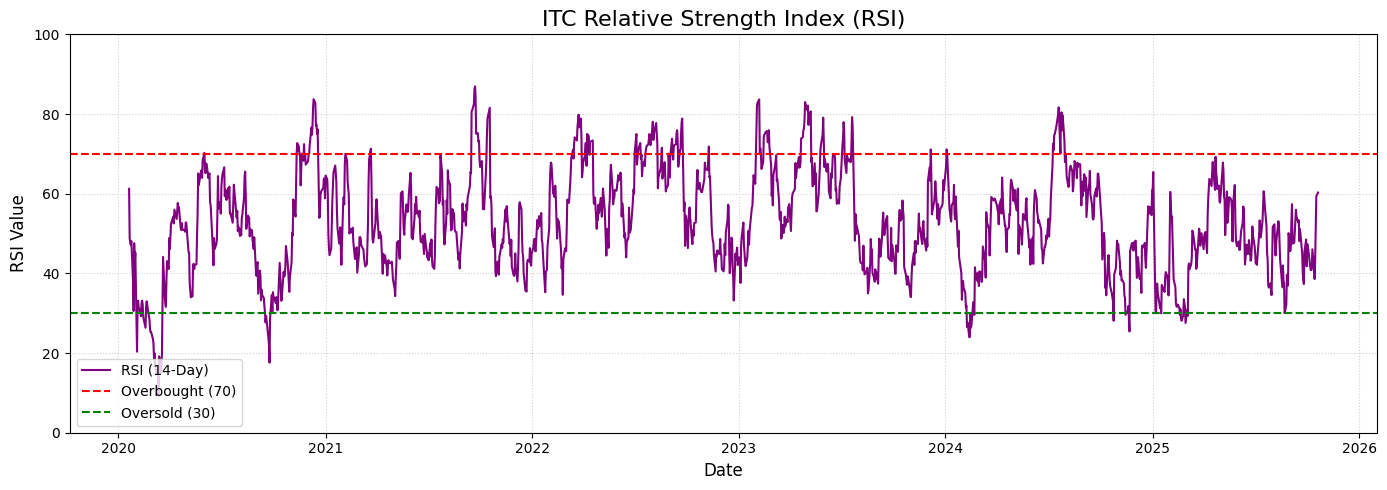

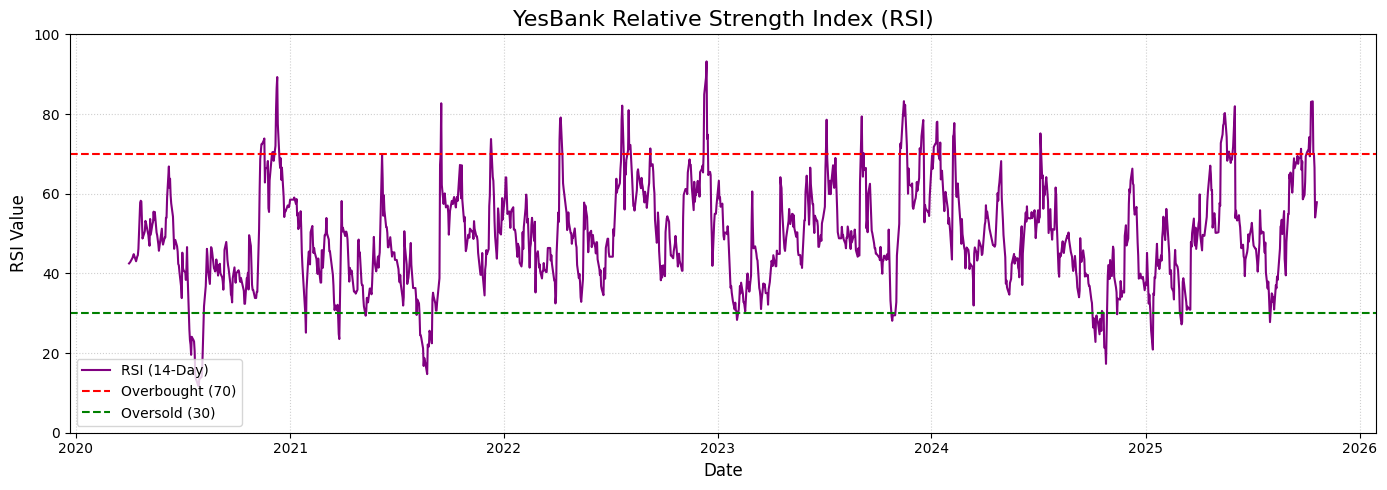

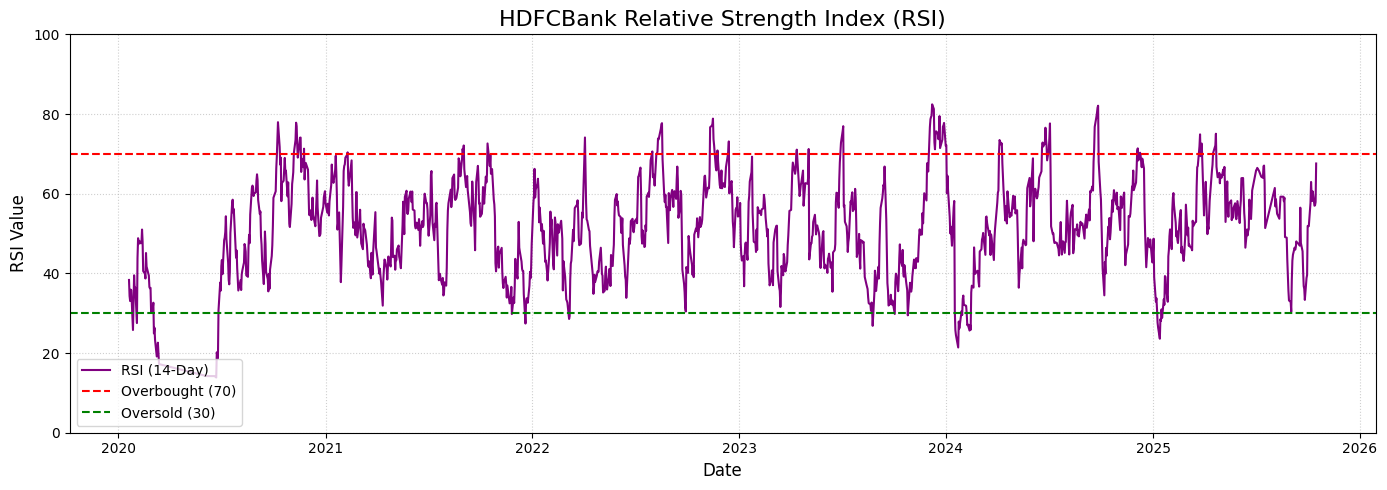

--- All RSI plots generated. ---


In [17]:
def calculate_rsi(df, window=14):
    """Calculates the 14-day Relative Strength Index (RSI)."""
    # Calculate daily price change
    delta = df['Close'].diff()

    # Separate gains (up) and losses (down)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate Exponentially Weighted Moving Average (EWMA) of gains and losses (Wilder's Smoothing)
    avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window - 1, min_periods=window).mean()

    # Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    return rsi

# --- 2. Calculate Indicators and Plot RSI for All 5 Datasets ---

print("--- Calculating 14-Day RSI and Generating Plots ---")

for company, df in processed_stock_data.items():

    # A. Calculate RSI (and MAs for general completeness/feature engineering)
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()
    df['RSI'] = calculate_rsi(df)

    # B. Prepare for Plotting
    # Drop rows with NaN RSI values (initial 14 days) for a clean plot
    df_plot = df.dropna(subset=['RSI'])

    if not df_plot.empty:
        plt.figure(figsize=(14, 5))

        # Plot the RSI line
        plt.plot(df_plot["Date"], df_plot["RSI"], label="RSI (14-Day)", color="purple")

        # Plot Overbought (70) and Oversold (30) thresholds
        plt.axhline(70, color="red", linestyle="--", label="Overbought (70)")
        plt.axhline(30, color="green", linestyle="--", label="Oversold (30)")

        # Set Plot Properties
        plt.title(f"{company} Relative Strength Index (RSI)", fontsize=16)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("RSI Value", fontsize=12)
        plt.ylim(0, 100) # RSI is always between 0 and 100
        plt.legend(loc='lower left')
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping plot for {company}: Not enough data points to calculate RSI.")

print("--- All RSI plots generated. ---")

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Dictionaries to hold the final processed data and the trained models
# ml_data contains: X_train_scaled, X_test_scaled, y_train, y_test
ml_data = {}
models = {}

print("--- Data Preparation & Feature Scaling Confirmation ---")

for company, df in processed_stock_data.items():

    # Ensure data is clean (required for indicators like MA and RSI)
    df_clean = df.dropna(subset=['MA_20', 'MA_50', 'RSI'])

    if df_clean.empty:
        print(f"Skipping {company}: DataFrame is empty after cleaning.")
        continue

    # 1. Define X and y
    features = ['Open', 'High', 'Low', 'Volume', 'MA_20', 'MA_50', 'RSI']
    X = df_clean[features]
    y = df_clean['Close']

    # 2. Split Data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        shuffle=False
    )

    # 3. Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Store the results
    ml_data[company] = {
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test
    }

    print(f"✅ Data prepared for {company}. Ready for training.")

--- Data Preparation & Feature Scaling Confirmation ---
✅ Data prepared for TCS. Ready for training.
✅ Data prepared for Infosys. Ready for training.
✅ Data prepared for ITC. Ready for training.
✅ Data prepared for YesBank. Ready for training.
✅ Data prepared for HDFCBank. Ready for training.


In [22]:
# Dictionary to store trained LR models and predictions
models_lr = {}

print("--- 1. Training and Predicting with Linear Regression ---")

for company, data in ml_data.items():

    # Retrieve scaled data
    X_train_scaled = data['X_train_scaled']
    X_test_scaled = data['X_test_scaled']
    y_train = data['y_train']

    # Initialize and Train Model
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)

    # Make Prediction
    y_pred_lr = lr.predict(X_test_scaled)

    # Store results
    models_lr[company] = {'model': lr, 'y_pred': y_pred_lr}

    print(f"✅ Linear Regression model trained and predicted for {company}.")

--- 1. Training and Predicting with Linear Regression ---
✅ Linear Regression model trained and predicted for TCS.
✅ Linear Regression model trained and predicted for Infosys.
✅ Linear Regression model trained and predicted for ITC.
✅ Linear Regression model trained and predicted for YesBank.
✅ Linear Regression model trained and predicted for HDFCBank.


In [23]:

# Dictionary to store trained DT models and predictions
models_dt = {}

print("\n--- 2. Training and Predicting with Decision Tree Regressor ---")

for company, data in ml_data.items():

    # Retrieve scaled data
    X_train_scaled = data['X_train_scaled']
    X_test_scaled = data['X_test_scaled']
    y_train = data['y_train']

    # Initialize and Train Model
    # Using random_state for reproducibility
    dt = DecisionTreeRegressor(random_state=42)
    dt.fit(X_train_scaled, y_train)

    # Make Prediction
    y_pred_dt = dt.predict(X_test_scaled)

    # Store results
    models_dt[company] = {'model': dt, 'y_pred': y_pred_dt}

    print(f"✅ Decision Tree model trained and predicted for {company}.")


--- 2. Training and Predicting with Decision Tree Regressor ---
✅ Decision Tree model trained and predicted for TCS.
✅ Decision Tree model trained and predicted for Infosys.
✅ Decision Tree model trained and predicted for ITC.
✅ Decision Tree model trained and predicted for YesBank.
✅ Decision Tree model trained and predicted for HDFCBank.


In [24]:
from sklearn.ensemble import RandomForestRegressor

# Dictionary to store trained RF models and predictions
models_rf = {}

print("\n--- 3. Training and Predicting with Random Forest Regressor ---")

for company, data in ml_data.items():

    # Retrieve scaled data
    X_train_scaled = data['X_train_scaled']
    X_test_scaled = data['X_test_scaled']
    y_train = data['y_train']

    # Initialize and Train Model
    # n_estimators=100 is standard; n_jobs=-1 uses all available cores
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train_scaled, y_train)

    # Make Prediction
    y_pred_rf = rf.predict(X_test_scaled)

    # Store results
    models_rf[company] = {'model': rf, 'y_pred': y_pred_rf}

    print(f"✅ Random Forest model trained and predicted for {company}.")


--- 3. Training and Predicting with Random Forest Regressor ---
✅ Random Forest model trained and predicted for TCS.
✅ Random Forest model trained and predicted for Infosys.
✅ Random Forest model trained and predicted for ITC.
✅ Random Forest model trained and predicted for YesBank.
✅ Random Forest model trained and predicted for HDFCBank.


In [25]:

# Dictionary to hold all R2 scores
r2_scores = {}

print("\n--- 4. Model Performance Evaluation (R-squared Score) ---")

for company in ml_data.keys():

    # Get the true test values
    y_test = ml_data[company]['y_test']

    # Get predictions from the three models
    y_pred_lr = models_lr[company]['y_pred']
    y_pred_dt = models_dt[company]['y_pred']
    y_pred_rf = models_rf[company]['y_pred']

    # Calculate R2 Score for each model
    r2_lr = r2_score(y_test, y_pred_lr)
    r2_dt = r2_score(y_test, y_pred_dt)
    r2_rf = r2_score(y_test, y_pred_rf)

    r2_scores[company] = {
        'Linear Regression R2': r2_lr,
        'Decision Tree R2': r2_dt,
        'Random Forest R2': r2_rf
    }

# Display the results in a formatted table
df_r2 = pd.DataFrame(r2_scores).T

print("\nModel Comparison (R-squared Score on Test Data):")
print(df_r2.to_markdown(floatfmt=".6f"))


--- 4. Model Performance Evaluation (R-squared Score) ---

Model Comparison (R-squared Score on Test Data):
|          |   Linear Regression R2 |   Decision Tree R2 |   Random Forest R2 |
|:---------|-----------------------:|-------------------:|-------------------:|
| TCS      |               0.998632 |           0.992186 |           0.996264 |
| Infosys  |               0.997880 |           0.985141 |           0.992214 |
| ITC      |               0.996017 |           0.973577 |           0.988146 |
| YesBank  |               0.993631 |           0.956122 |           0.982359 |
| HDFCBank |               0.997896 |          -0.544141 |          -0.343035 |
